In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Any results you write to the current directory are saved as output.

In [47]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split, sampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, models
import random
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import math
import xml.etree.ElementTree as ET

import torch
import torchvision
from tqdm import tqdm

In [48]:
#Cropping the image based on Train images

def crop_image(breed, dog, data_dir):
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    img = img[ymin:ymax, xmin:xmax, :]
    return img

(151, 256, 3)
(332, 256, 3)
(272, 255, 3)
(320, 227, 3)


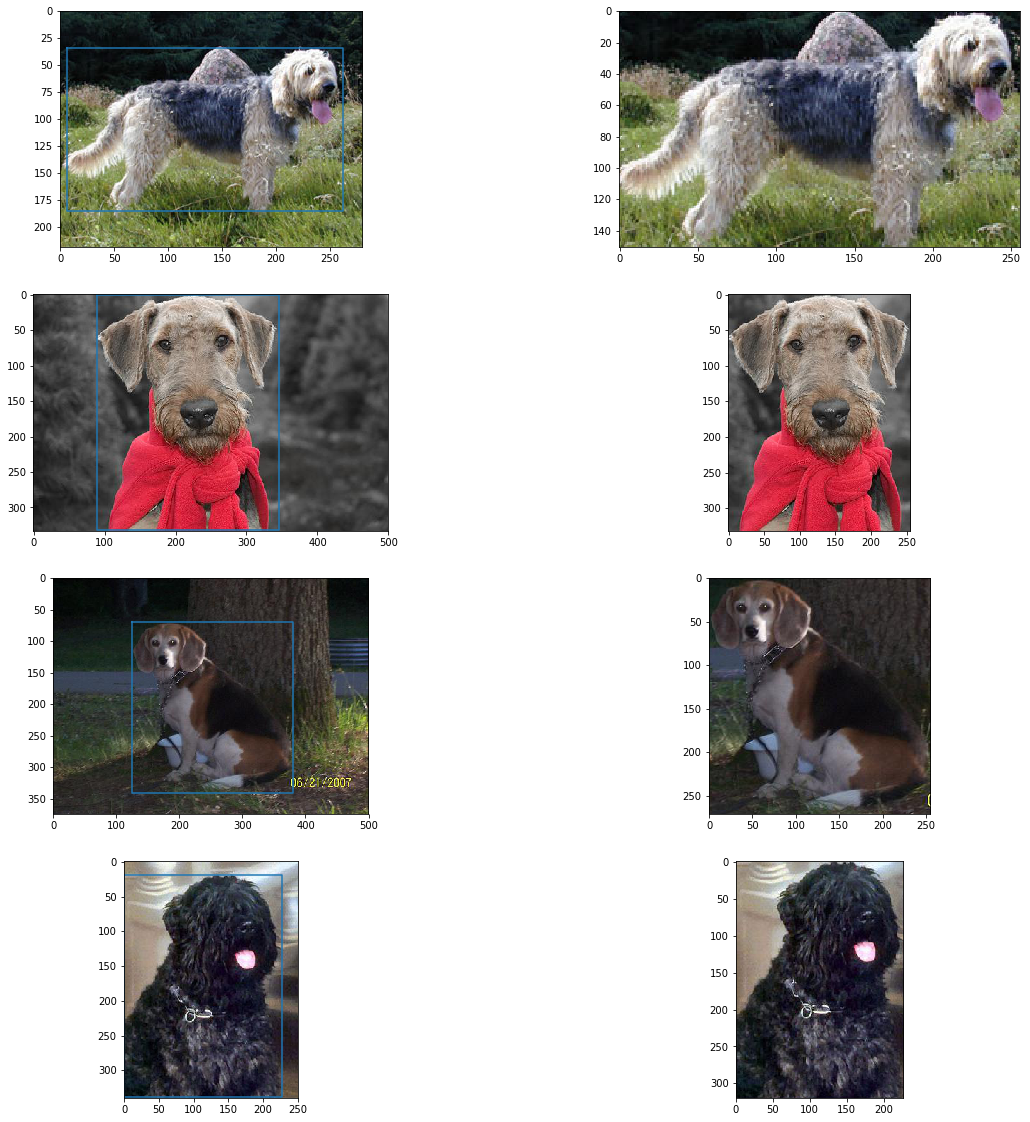

In [49]:
data_dir = '/kaggle/input/stanford-dogs-dataset/'
breed_list = os.listdir(data_dir + 'images/Images/')

plt.figure(figsize=(20, 20))

for i in range(4):
    
    plt.subplot(421 + (i*2))
    
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir(data_dir + 'annotations/Annotation/' + breed))
    img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
    plt.imshow(img)
    
    tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
    
    crop_img = crop_image(breed, dog, data_dir)
    print(crop_img.shape)
    plt.subplot(422 + (i*2))
    plt.imshow(crop_img)

In [50]:
if 'cropped_data' not in os.listdir():
    
    os.mkdir('cropped_data')
    
    for breed in breed_list:
        os.mkdir('cropped_data/' + breed)
    
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('cropped_data'))))

Created 120 folders to store cropped images of the different breeds.


In [51]:
for breed in tqdm(os.listdir('cropped_data')):
    
    for file in os.listdir(data_dir + 'annotations/Annotation/' + breed):
        
        img = Image.open(data_dir + 'images/Images/' + breed + '/' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('cropped_data/' + breed + '/' + file + '.jpg')

100%|██████████| 120/120 [02:26<00:00,  1.22s/it]


In [52]:
img_count = 0

for folder in os.listdir('cropped_data'):
    
    for _ in os.listdir('cropped_data/' + folder):    
        img_count += 1
    
print('No. of Images: {}'.format(img_count))

No. of Images: 20580


In [144]:
# Data Augmentation
batch_size = 256
image_size = 299

image_transforms = {
    
    'train':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
    ]),
    'val':torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=image_size),
            torchvision.transforms.CenterCrop(size=image_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                             std=(0.229, 0.224, 0.225))
        ])
}

In [145]:
all_data = datasets.ImageFolder(root='cropped_data')

In [146]:
all_data.classes

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [147]:
train_data_len = int(len(all_data) * 0.8)
valid_data_len = int((len(all_data) - train_data_len) / 2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['val']
test_data.dataset.transform = image_transforms['val']

print(len(train_data), len(val_data), len(test_data))

16464 2058 2058


In [148]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [149]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

torch.Size([256, 3, 299, 299]) torch.Size([256])


In [ ]:
#!ls 

In [150]:
resnet = models.resnet18()
resnet.load_state_dict(torch.load('../input/pretrained-pytorch-models/resnet18-5c106cde.pth'), strict=False)

# freezing parameters
for param in resnet.parameters():
    param.requires_grad = False

layers = list(models.resnet18().children())[:-2]
resnet = nn.Sequential(*layers).cuda()


In [191]:
N = 1
#size of the input image -----> batch_sz*no_channel * length * breadth
x = resnet(torch.randn(1, 3, image_size, image_size).cuda())
#size of output from model ----> batch_size * no of features * feature_map * feature_map
x.shape
#image_size

torch.Size([1, 512, 10, 10])

In [170]:
# from torch import FloatTensor

# def new_parameter(*size):
#     out = nn.Parameter(FloatTensor(*size), requires_grad=True)
#     torch.nn.init.xavier_normal_(out)
#     return out

# class Attention(nn.Module):
    
#     def __init__(self, attention_size):
#         super(Attention, self).__init__()
#         self.attention = new_parameter(attention_size, 1)

#     def forward(self, x_in):
#         # after this, we have (bs, feature_size, feature_size) with a diff weight per each cell
#         #score = torch.matmul(x_in, self.attention).squeeze()
#         score = self.attention
        
#         #NN-attention
#         m = nn.Softmax(dim=0)
#         output = m(score)
#         #attention_score = output.view(x_in.size(0), x_in.size(1), 1)
#         attention_score = 
#         #attention_score = F.softmax(attention_score).view(x_in.size(0), x_in.size(1), 1)
#         scored_x = x_in * attention_score

#         # now, sum across dim 1 to get the expected feature vector
#         condensed_x = torch.sum(scored_x, dim=1)

#         return condensed_x

In [268]:
class Self_Attn(nn.Module):
    
    """ Self attention Layer"""
    
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1).cuda()
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1).cuda()
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1).cuda()
        self.gamma = nn.Parameter(torch.zeros(1)).cuda()

        self.softmax  = nn.Softmax(dim=-1) #
    
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        out1 = out.view(1,512,100).permute(0,2,1)
        out2 = torch.sum(out1, dim=1)
        
        return out2

In [235]:
# x = torch.randn(1,512,10,10)

# #m_batchsize,C,width ,height = x.size()
# attn = Self_Attn( 512, 'relu')
# out = attn(x)

# out.shape
# out = out.view(1,512,100)
# out1 = out.view(1,512,100).permute(0,2,1)
# torch.sum(out1, dim=1).shape

# attention_score = new_parameter(10,1)
# attention_score
# m = nn.Softmax(dim=0)
# #input_data = torch.randn(12, 1)
# output = m(attention_score)
# output.shape

In [269]:
resnet = models.resnet18()
resnet.load_state_dict(torch.load('../input/pretrained-pytorch-models/resnet18-5c106cde.pth'), strict=False)

# freezing parameters
for param in resnet.parameters():
    param.requires_grad = False

layers = list(models.resnet18().children())[:-2]
resnet = nn.Sequential(*layers)


In [270]:
# N = 1
# #size of the input image -----> batch_sz*no_channel * length * breadth
# x = resnet(torch.randn(1, 3, 299, 299).cuda())
# #size of output from model ----> batch_size * no of features * feature_map * feature_map
# x.shape


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [271]:
#feat = 512
fmap_size = 10


class CNN_Resnet_Attention(nn.Module):
    def __init__(self, fine_tune=False):
        super(CNN_Resnet_Attention, self).__init__()
        
        resnet = models.resnet18(pretrained=False)
        resnet.load_state_dict(torch.load('../input/pretrained-pytorch-models/resnet18-5c106cde.pth'))
        
        
        # freezing parameters
        if not fine_tune:
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            
            for param in resnet.parameters():
                param.requires_grad = True

        layers = list(resnet.children())[:-2]
        self.features = nn.Sequential(*layers)
        self.attn = Attention(512)
        self.fc = nn.Linear(512, 120)
        self.dropout = nn.Dropout(0.5)
        
        # Initialize the fc layers.
        nn.init.xavier_normal_(self.fc.weight.data)
        
        if self.fc.bias is not None:
            torch.nn.init.constant_(self.fc.bias.data, val=0)
        
    
        
    def forward(self, x):
        
        ## X: bs, 3, 299, 299
        ## N = bs
        N = x.size()[0]
        
        ## x : bs, 512, 10, 10
        x = self.features(x)
        
        #Attention
        self.attn1 = Self_Attn(512, 'relu')
        
        
        # bs, (512 * 100) 
        #x = x.view(N, 512, fmap_size ** 2)
        
        # Batch matrix multiplication
        #x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        #x = torch.sqrt(x + 1e-5)
        x = self.attn1(x)
        #x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [272]:
device = 'cuda:0'

In [273]:
model = CNN_Resnet_Attention().to(device)

In [280]:
model.cuda()

CNN_Resnet_Attention(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [275]:
#print (model)
next(model.parameters()).is_cuda

True

In [276]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [277]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [278]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader,
          val_loader, 
          save_location, 
          early_stop=3, 
          n_epochs=20, 
          print_every=1):

    #Initializing some variables
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    #Loop starts here
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        
        ### batch control
        ii = 0
        
        for data, label in train_loader:
            
            ii += 1
            
            data, label = data.to(device), label.to(device)
            output = model(data)
            
            loss = criterion(output, label)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            
            
            # Calculate accuracy by finding max log probability
            # first output gives the max value in the row(not what we want), second output gives index of the highest val
            _, pred = torch.max(output, dim=1)
            
            # using the index of the predicted outcome above, torch.eq() will check prediction index against label index to see if prediction is correct(returns 1 if correct, 0 if not)
            correct_tensor = pred.eq(label.data.view_as(pred))
            
            #tensor must be float to calc average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)
            
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')
        
        model.epochs += 1
        
        with torch.no_grad():
            
            model.eval()
            
            for data, label in val_loader:
                
                data, label = data.to(device), label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)
                
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)
            
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                
                torch.save({
                    'state_dict': model.state_dict()
                    #'idx_to_class': model.idx_to_class
                }, save_location)
                
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                
                stop_count += 1
                
                # Below is the case where we handle the early stop case
                if stop_count >= early_stop:
                    
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history
    
    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    
    return model, history

In [279]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='dog_bcnn_resnet_attention.pt',
    early_stop=3,
    n_epochs=50,
    print_every=1)

RuntimeError: shape '[1, 512, 100]' is invalid for input of size 13107200